In [2]:
from typing import List
import re
from textwrap import wrap

import stanza
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

from matplotlib import pyplot as plt

from scripts.dataset.process_task8_files import tag_token, get_path


In [3]:
file_path = "dataset/semeval_task8/original/TRAIN_FILE.TXT"
lines_num = [0, 16, 20, 2092, 2096]



In [4]:
def process_text(lines: List[str]):

    # detect tokens betweem entity tags <e1><\ or <e2>
    entity_regex = re.compile(r"(?<=<e[12]>)\w+(?:\W? ?\w+)*(?=</e[12]>)")
    # detect entity tags themselves <e1>, <e2>
    tag_regex = re.compile(r"</?e[12]>")
    # detect the douple quotes at the beginning and the end of the text
    dquotes_regex = re.compile(r"^\"|\"$")

    ent_tags = {"e1": "1", "e2": "2", "other": "o"}

    nlp = stanza.Pipeline(
        lang="en",
        processors="tokenize,pos,lemma,depparse",
        tokenize_no_ssplit=True,
        model_dir="/srv/data/zarzouram/resources/stanza/models")

    e_right = []
    e_left = []
    tokens = []
    dep_tags = []
    dep_trees = []
    paths = []
    for text in lines:
        _idx, text = text.split("\t")  # read sample text and sample id
        text = dquotes_regex.sub(string=text.strip(), repl="")  # remove ""
        matches = list(entity_regex.finditer(text))  # find tokens betn tags
        text_notags = tag_regex.sub(string=text,
                                    repl="")  # remove tags from text

        # get the start and end positions, corrected for tags removal
        e1s, e1e = matches[0].start() - 4, matches[0].end() - 4
        e2s, e2e = matches[1].start() - 13, matches[1].end() - 13

        # tokenization, and pos, dependency tagging
        doc = nlp(text_notags)
        token: List[str] = []
        e1_ids: List[str] = []
        e2_ids: List[str] = []
        dep_tree: List[int] = []  # dependency tree
        dep_tag: List[str] = []  # dependency tags
        for sent in doc.sentences:
            for word in sent.words:
                token.append(f"{word.text.lower()}")

                # extract token tagged by <e1> and <e2>
                e_tag = tag_token([e1s, e2s], [e1e, e2e], word.start_char,
                                  ent_tags)
                if e_tag == ent_tags["e1"]:
                    e1_ids.append(word.id - 1)
                elif e_tag == ent_tags["e2"]:
                    e2_ids.append(word.id - 1)

                # dependency tree in a list:
                dep_tree.append(word.head - 1 if word.head > 0 else word.id -
                                1)
                dep_tag.append(word.deprel)  # dependency tag

        # dependency tree, remove self looping at root node
        dep_g = [(ud, vd) for ud, vd in enumerate(dep_tree) if ud != vd]
        dep_g = nx.DiGraph(dep_g)

        # get shortest path from e1 to e2
        u, v = get_path(tree=dep_tree, left=e1_ids[-1], right=e2_ids[-1])
        path_g = nx.DiGraph(list(zip(u, v)))

        tokens.append(token)
        e_left.append(e1_ids)
        e_right.append(e2_ids)
        dep_tags.append(dep_tag)
        dep_trees.append(dep_g)
        paths.append(path_g)

    return tokens, e_left, e_right, dep_tags, dep_trees, paths



In [5]:
def plot_tree(trees, paths, lefts, rights, dep_tags, tokens, texts):

    # Different nodes colors
    color = "lightsteelblue"
    color_path = "rosybrown"
    color_fromto = "lightcoral"

    # get path from right to left anf from left to right
    for tree, path, left, right, dep_tag, token, text in zip(
            trees, paths, lefts, rights, dep_tags, tokens, texts):

        left, right = left[-1], right[-1]
        tree_pos = graphviz_layout(tree, prog="dot")
        path_pos = graphviz_layout(path, prog="dot")

        # Draw the original tree and the path sode by side
        fig = plt.figure(figsize=(18, 15), constrained_layout=True)
        spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
        fig_title = "\n".join(wrap(text, 120))
        fig.suptitle(fig_title, fontsize=18)

        ax2 = fig.add_subplot(spec[0, 1])
        nx.draw(path, path_pos, with_labels=True, ax=ax2, node_size=2000)
        n = path.number_of_nodes()
        e = path.number_of_edges()

        # Change the color of the nodes of the extracted path
        node_color = []
        for node in tree:
            if node in [left, right]:
                node_color.append(color_fromto)
            elif node in path.nodes().keys():
                node_color.append(color_path)
            else:
                node_color.append(color)

        edge_labels = {(n1, n2): f"{dep_tag[n1]}" for n1, n2 in tree.edges}
        node_labels = {n: "\n".join(wrap(token[n], 6)) for n in tree.nodes()}

        ax1 = fig.add_subplot(spec[0, 0])
        nx.draw(tree,
                tree_pos,
                with_labels=True,
                labels=node_labels,
                ax=ax1,
                node_color=node_color,
                node_size=2100,
                edgecolors="black")
        nx.draw_networkx_edge_labels(tree,
                                     tree_pos,
                                     ax=ax1,
                                     edge_labels=edge_labels,
                                     font_color="red",
                                     font_size=15)

        for ax in fig.get_axes():
            ax.tick_params(bottom=False,
                           labelbottom=False,
                           left=False,
                           labelleft=False)

        plt.show()



In [6]:
with open(file_path, "r") as file:
    texts = file.readlines()

texts = [texts[ln_id] for ln_id in lines_num]
tokens, e_left, e_right, dep_tags, dep_trees, paths = process_text(texts)


2022-05-17 10:47:28 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-05-17 10:47:28 INFO: Use device: gpu
2022-05-17 10:47:28 INFO: Loading: tokenize
2022-05-17 10:47:31 INFO: Loading: pos
2022-05-17 10:47:31 INFO: Loading: lemma
2022-05-17 10:47:31 INFO: Loading: depparse
2022-05-17 10:47:32 INFO: Done loading processors!


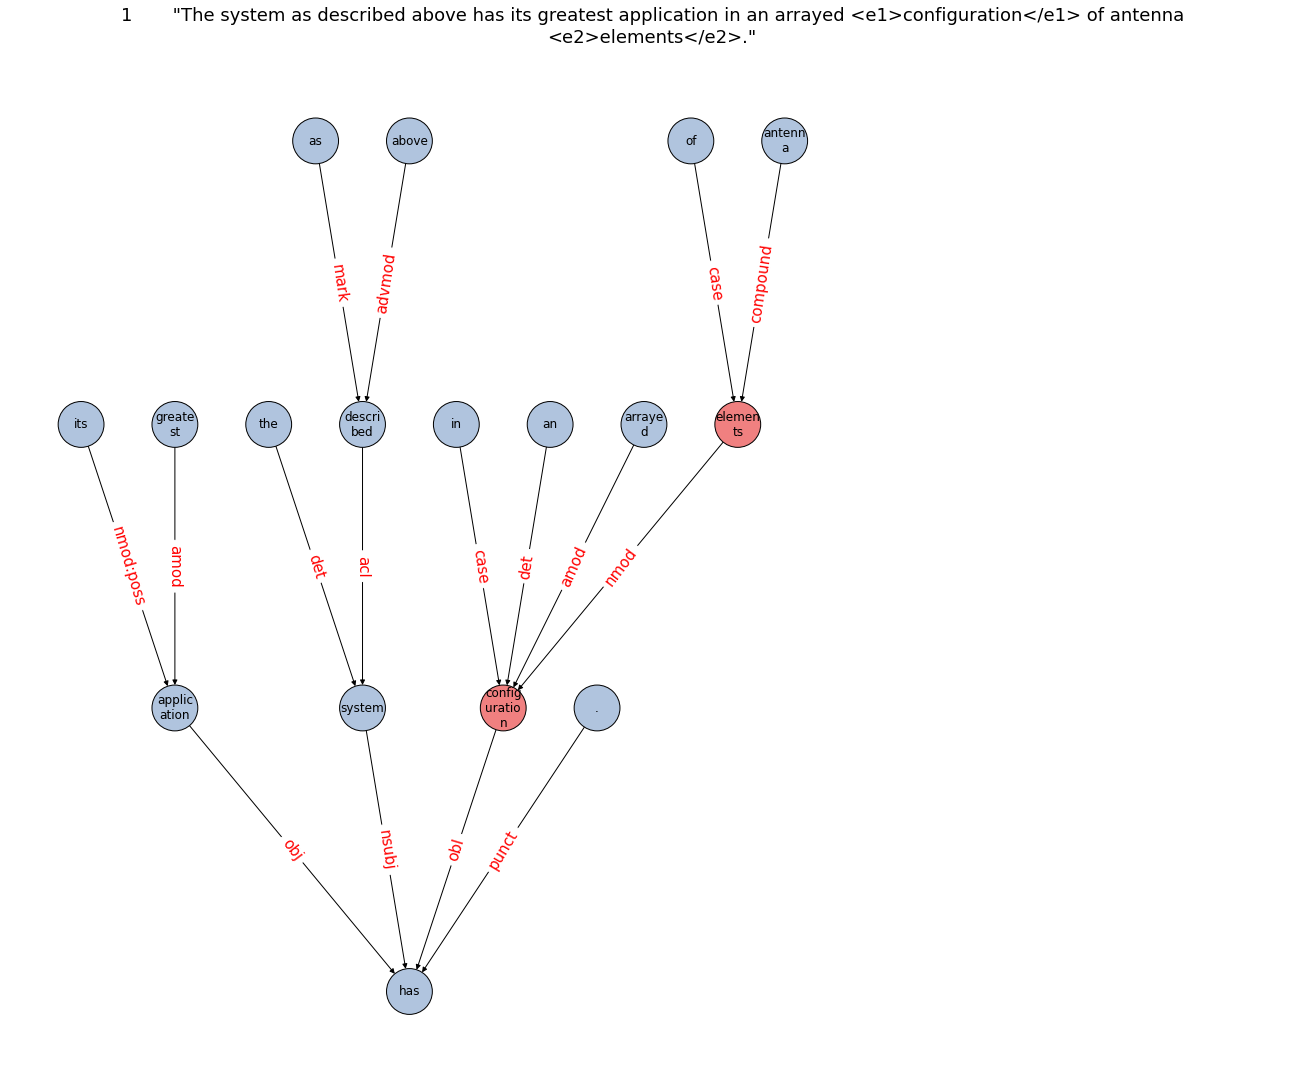

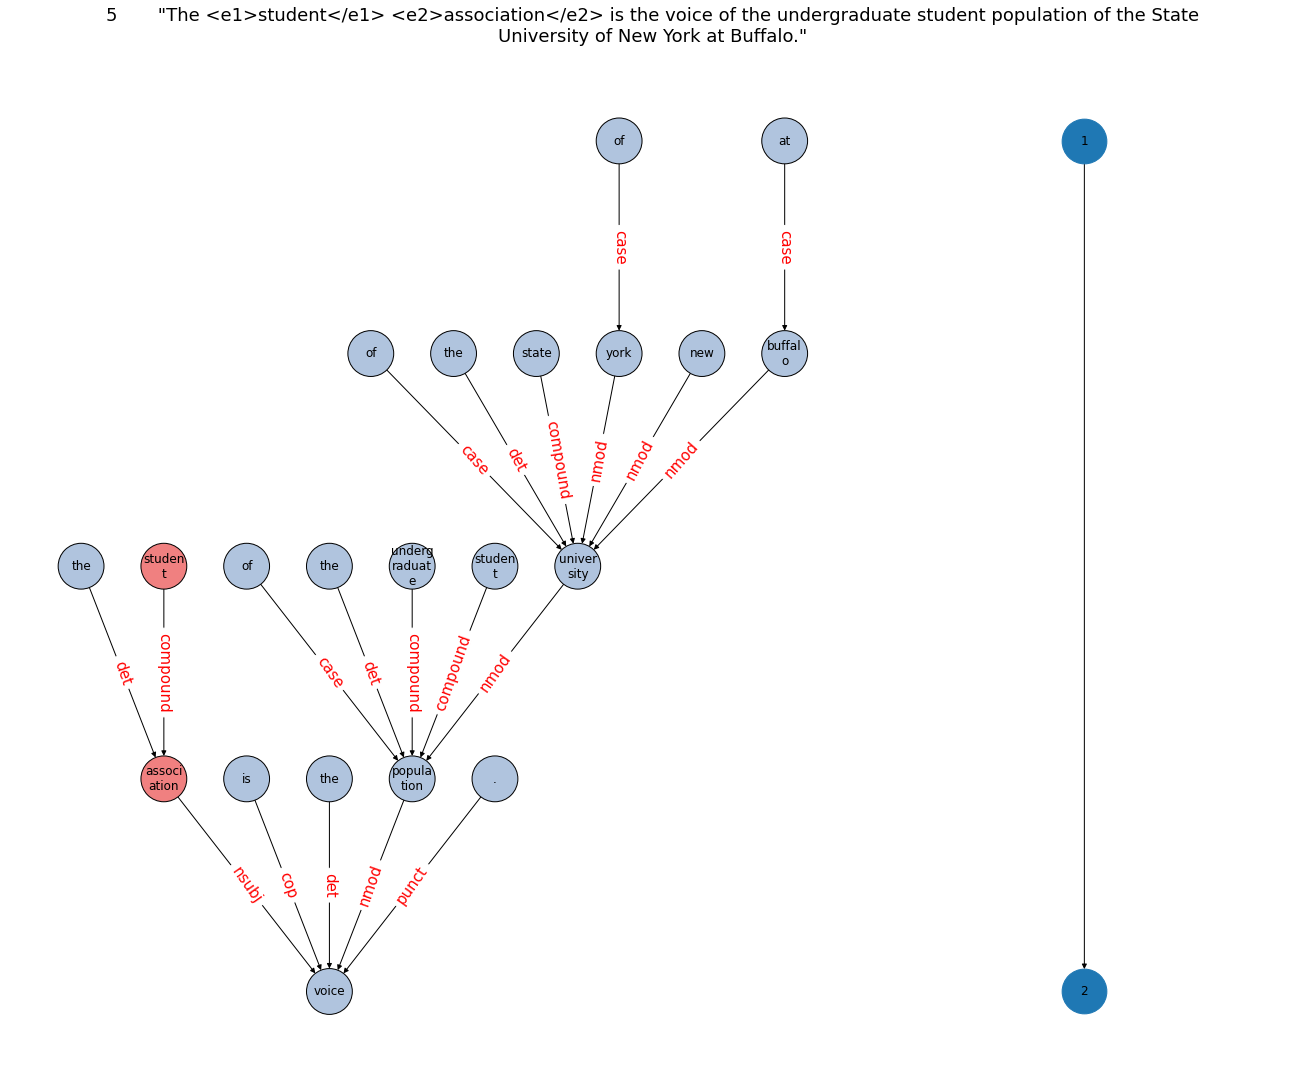

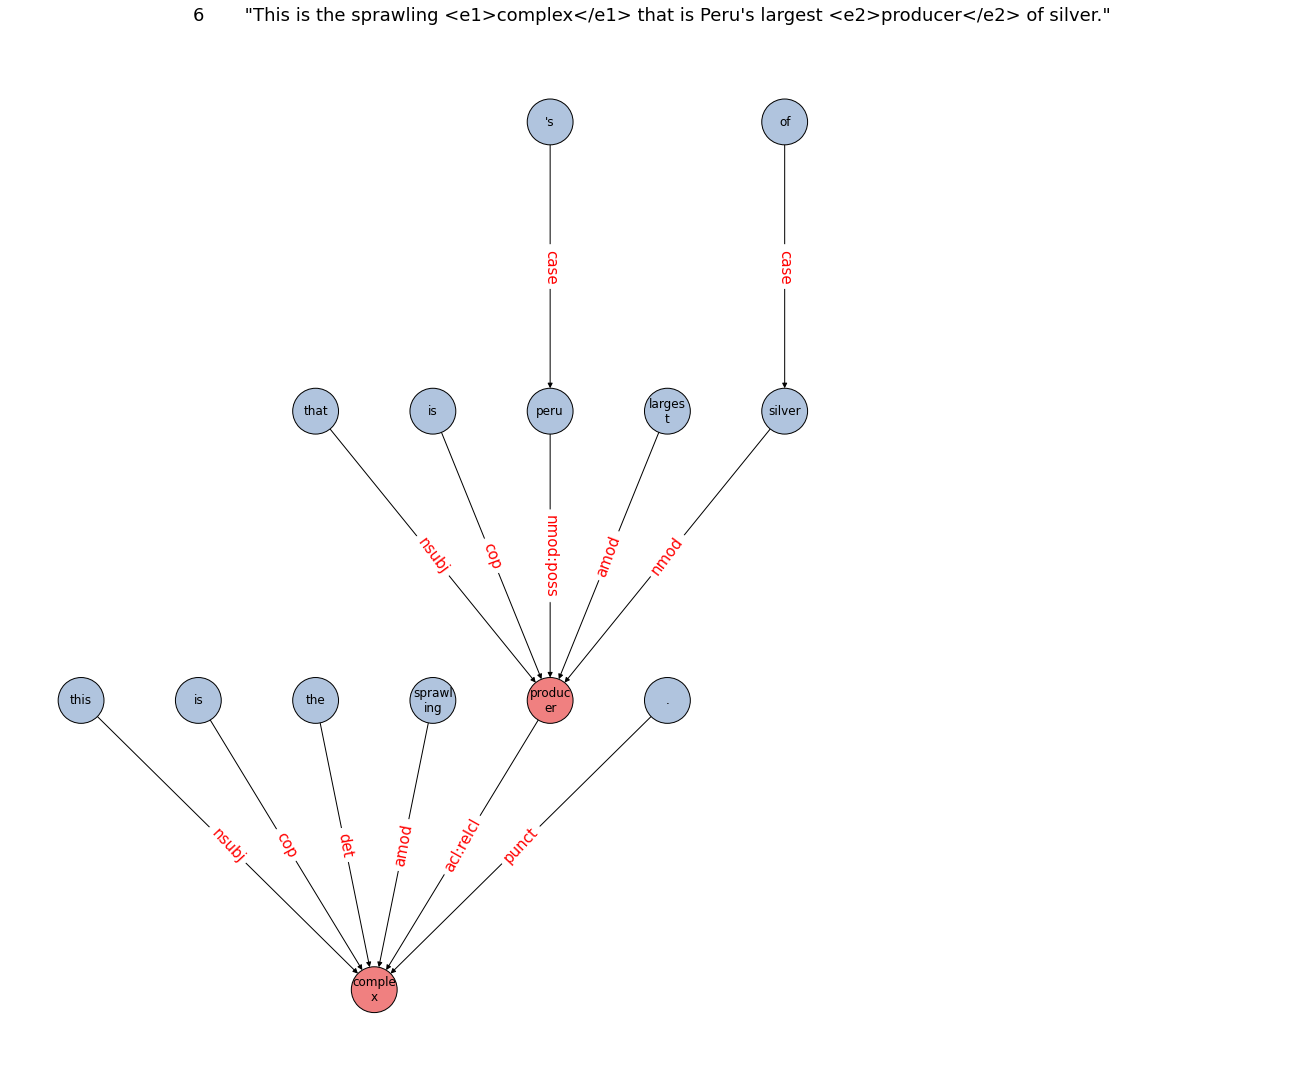

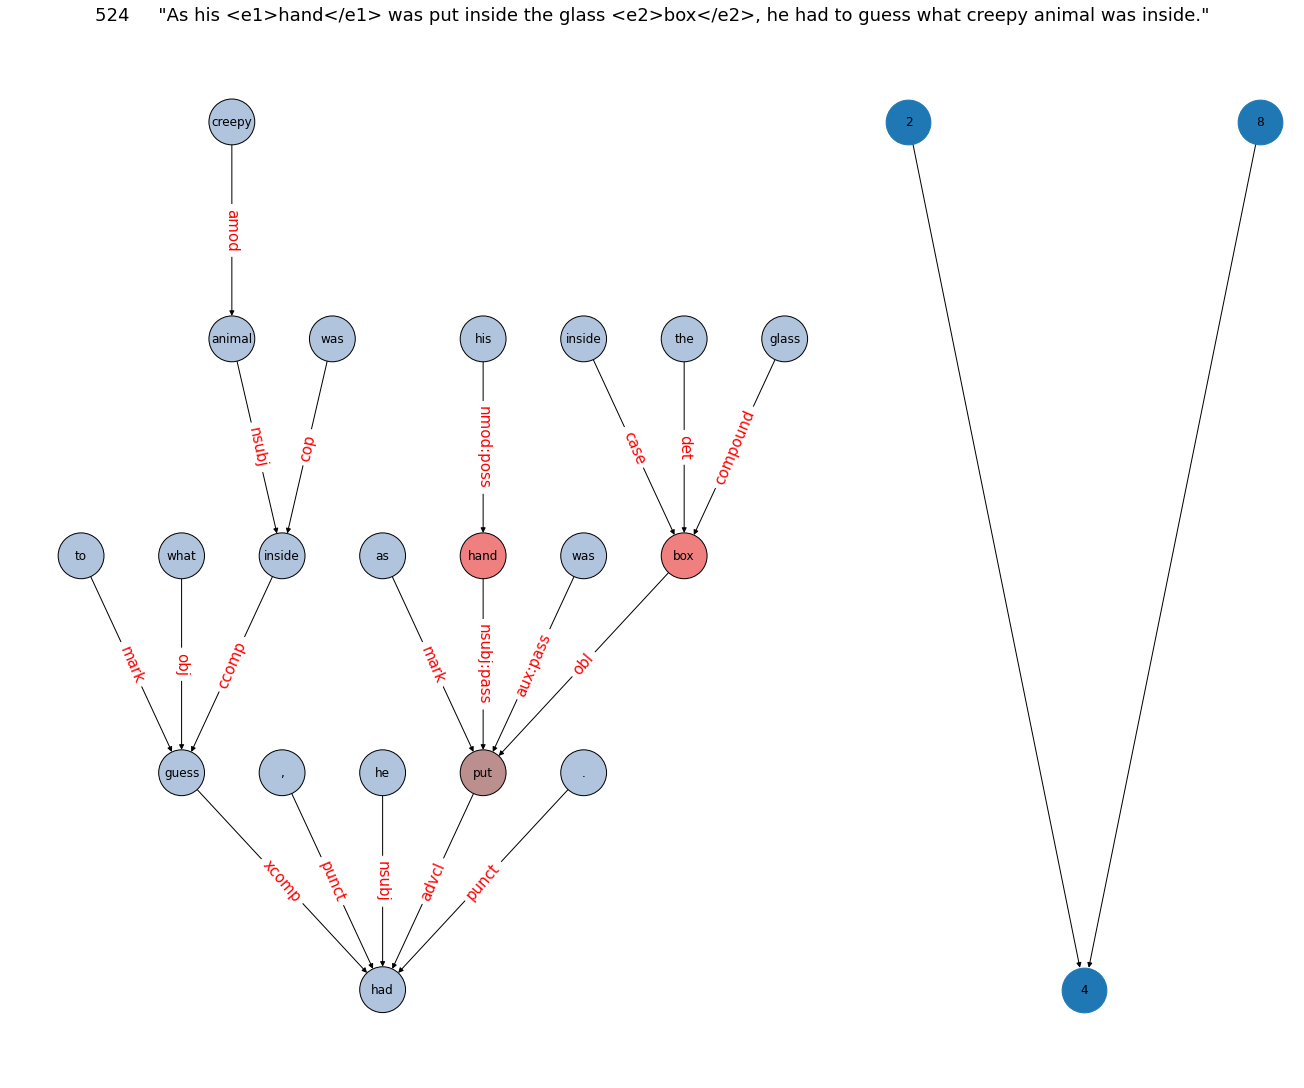

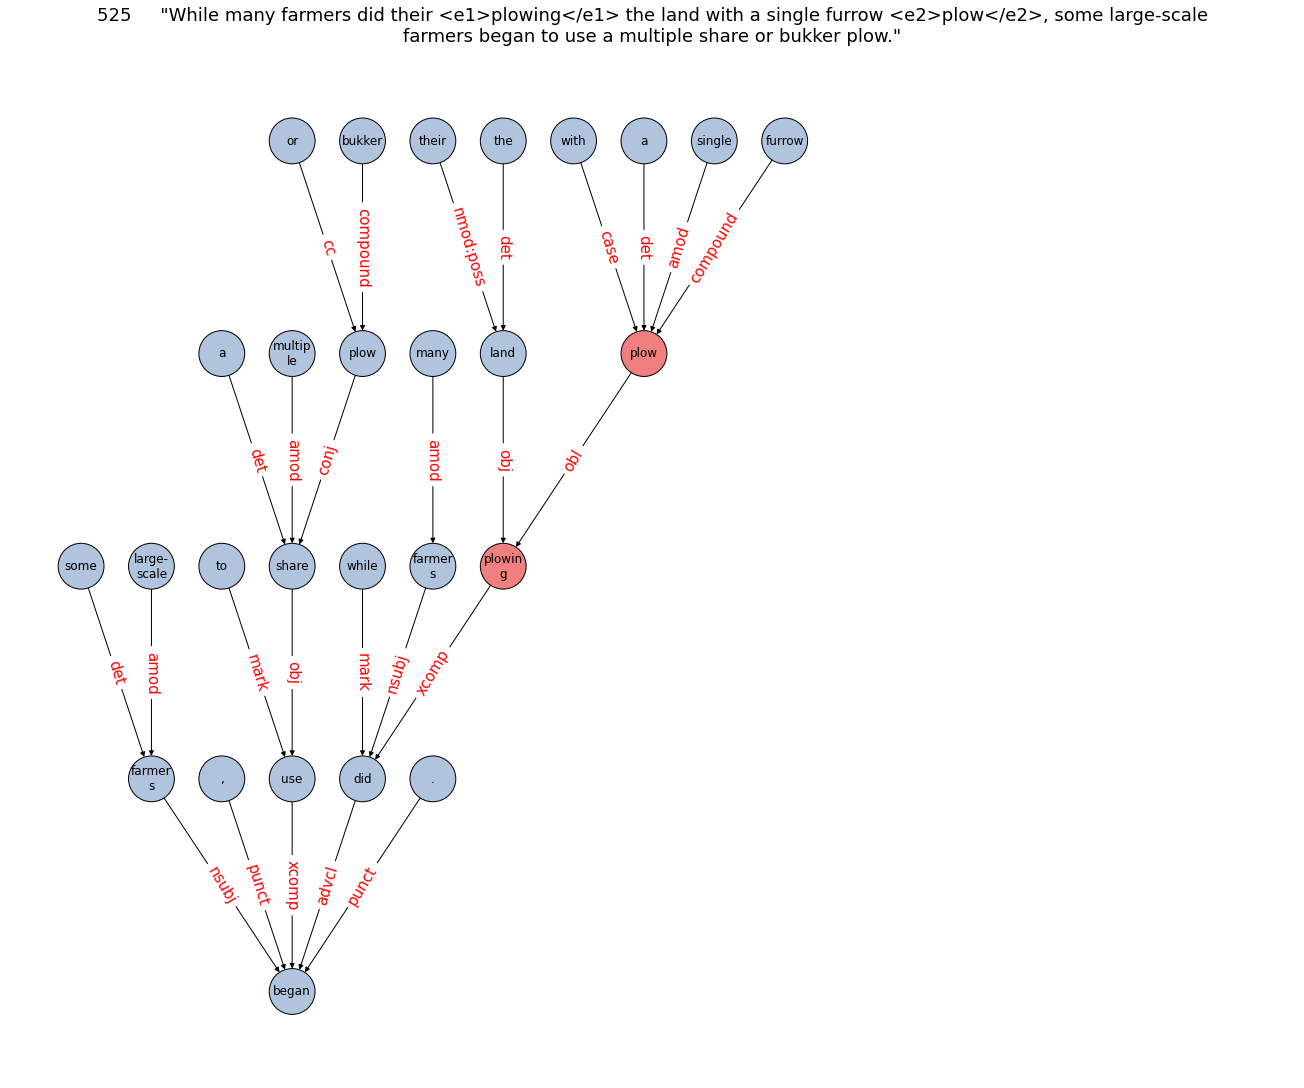

In [7]:
plot_tree(dep_trees, paths, e_left, e_right, dep_tags, tokens, texts)
